# AIRLINE FREQUENT FLYER

In this project, we will try to analyze the characteristics of airline member, based on various category. The result from this analysis, will help identify the right marketing steps.

We use **flight.csv**, and using KMeans Clustering to help divide the data per cluster. **K-means clustering** is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean.

[source](https://en.wikipedia.org/wiki/K-means_clustering)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

numpy version :  1.21.6
pandas version :  1.3.5
seaborn version :  0.11.2


In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

## Data Collection

In [ ]:
# read the dataframe, remove all rows wit NULL values

df = pd.read_csv('flight.csv')
df = df.dropna()
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
5,56972,2/10/2008,9/29/2009,Male,6,guangzhou,guangdong,CN,64.0,3/31/2014,...,76946.0,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15


## Data Understanding

In [ ]:
# Find out dataframe information

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58255 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          58255 non-null  int64  
 1   FFP_DATE           58255 non-null  object 
 2   FIRST_FLIGHT_DATE  58255 non-null  object 
 3   GENDER             58255 non-null  object 
 4   FFP_TIER           58255 non-null  int64  
 5   WORK_CITY          58255 non-null  object 
 6   WORK_PROVINCE      58255 non-null  object 
 7   WORK_COUNTRY       58255 non-null  object 
 8   AGE                58255 non-null  float64
 9   LOAD_TIME          58255 non-null  object 
 10  FLIGHT_COUNT       58255 non-null  int64  
 11  BP_SUM             58255 non-null  int64  
 12  SUM_YR_1           58255 non-null  float64
 13  SUM_YR_2           58255 non-null  float64
 14  SEG_KM_SUM         58255 non-null  int64  
 15  LAST_FLIGHT_DATE   58255 non-null  object 
 16  LAST_TO_END        582

|   Variable   | Description   |
|--------------|---------------|
| `MEMBER_NO` | ID Member |
| `FFP_DATE`    | Frequent Flyer Program Join Date
| `FIRST_FLIGHT_DATE`  | First flight date
| `GENDER`      | Member's gender |
| `FFP_TIER`    | Tier of Frequent Flyer Program |
| `WORK_CITY` 	| Member's Hometown |
| `WORK_PROVINCE` | Member's Hometown province 
| `WORK_COUNTRY`  | Member's home country
| `AGE` 	   | Member's age
| `LOAD_TIME`   | Times when data collected
| `FLIGHT_COUNT`  | Amount of flight taken 
| `BP_SUM`     | Travel plan
| `SUM_YR_1`   | Fare Revenue
| `SUM_YR_2`   | Votes Prices
| `SEG_KM_SUM` | Total miles
| `LAST_FLIGHT_DATE`  | Last flight date
| `LAST_TO_END`   | Distance between latest flight with last flight  
| `AVG_INTERVAL`  | Average time distance 
| `MAX_INTERVAL`  | Maximum time distance 
| `EXCHANGE_COUNT`  | Point exchange
| `avg_discount`   | Member's average discount 	
| `Points_Sum`    | Member's point amount 	
| `Point_NotFlight` | Unused point

## Data Prepocessing

Here we re-check null values, check duplicated values, and change `FFP_DATE`, `FIRST_FLIGHT_DATE`, `LOAD_TIME` from string or object to datetime datatype. We also try to identified the numerical and categorical columns.

In [ ]:
# check again, is there any null values? by creating df_null dataframe

df_null = df.isnull().sum().reset_index()
df_null.columns = ['feature','missing_value']
df_null['percentage'] = round((df_null['missing_value']/len(df))*100,2)
df_null = df_null.sort_values('percentage', ascending=False).reset_index(drop=True)
df_null = df_null[df_null['percentage']>0]
df_null

,feature,missing_value,percentage


In [ ]:
# check is there any duplicated item?

df.duplicated().sum()

0

In [ ]:
# change FFP_DATE, FIRST_FLIGHT_DATE and LOAD_TIME to datetime datatype

df['FFP_DATE'] = pd.to_datetime(df['FFP_DATE'])
df['FIRST_FLIGHT_DATE'] = pd.to_datetime(df['FIRST_FLIGHT_DATE'])
df['LOAD_TIME'] = pd.to_datetime(df['LOAD_TIME'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58255 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          58255 non-null  int64         
 1   FFP_DATE           58255 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  58255 non-null  datetime64[ns]
 3   GENDER             58255 non-null  object        
 4   FFP_TIER           58255 non-null  int64         
 5   WORK_CITY          58255 non-null  object        
 6   WORK_PROVINCE      58255 non-null  object        
 7   WORK_COUNTRY       58255 non-null  object        
 8   AGE                58255 non-null  float64       
 9   LOAD_TIME          58255 non-null  datetime64[ns]
 10  FLIGHT_COUNT       58255 non-null  int64         
 11  BP_SUM             58255 non-null  int64         
 12  SUM_YR_1           58255 non-null  float64       
 13  SUM_YR_2           58255 non-null  float64       
 14  SEG_KM

In [ ]:
# drop MEMBER_NO, because we wont use it

df = df.drop('MEMBER_NO', axis = 1)
df.head()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
2,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
5,2008-02-10,2009-09-29,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,76946.0,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15


In [ ]:
# find numerical column

col_numericals = df.loc[:, (df.dtypes == int) | 
                        (df.dtypes == float)].columns.tolist()
col_numericals

['FFP_TIER',
 'AGE',
 'FLIGHT_COUNT',
 'BP_SUM',
 'SUM_YR_1',
 'SUM_YR_2',
 'SEG_KM_SUM',
 'LAST_TO_END',
 'AVG_INTERVAL',
 'MAX_INTERVAL',
 'EXCHANGE_COUNT',
 'avg_discount',
 'Points_Sum',
 'Point_NotFlight']

In [ ]:
# find categorical column

col_categoricals = df.loc[:, (df.dtypes != int) & (df.dtypes != float) & 
                          (df.columns != 'publish_daytype') & 
                          ((df.columns != 'trending_daytype'))].columns.tolist()
col_categoricals

['FFP_DATE',
 'FIRST_FLIGHT_DATE',
 'GENDER',
 'WORK_CITY',
 'WORK_PROVINCE',
 'WORK_COUNTRY',
 'LOAD_TIME',
 'LAST_FLIGHT_DATE']

## Descriptive Statistics

Here we statistical describe the dataframe

In [ ]:
# describe the dataframe

df.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000
mean,4.104849,42.228736,12.067634,11066.303682,5366.827963,5694.530650,17353.000910,171.255309,67.937285,167.349206,0.328384,0.720627,12742.648820,2.820548
std,0.378182,9.761965,14.236472,16283.209178,8103.595049,8710.724917,20969.886756,180.560120,77.449058,122.890446,1.148485,0.183895,20606.104272,7.500252
min,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,35.000000,3.000000,2608.000000,1016.000000,846.000000,4904.000000,28.000000,23.700000,81.000000,0.000000,0.612155,2872.500000,0.000000
50%,4.000000,41.000000,7.000000,5832.000000,2808.000000,2846.000000,10237.000000,104.000000,44.833333,144.000000,0.000000,0.711468,6487.000000,0.000000
75%,4.000000,48.000000,15.000000,13022.000000,6591.500000,6958.000000,21571.500000,258.000000,82.000000,228.000000,0.000000,0.808159,14527.000000,1.000000
max,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


## Exploratory Data Anaylysis

### Univariate Analysis

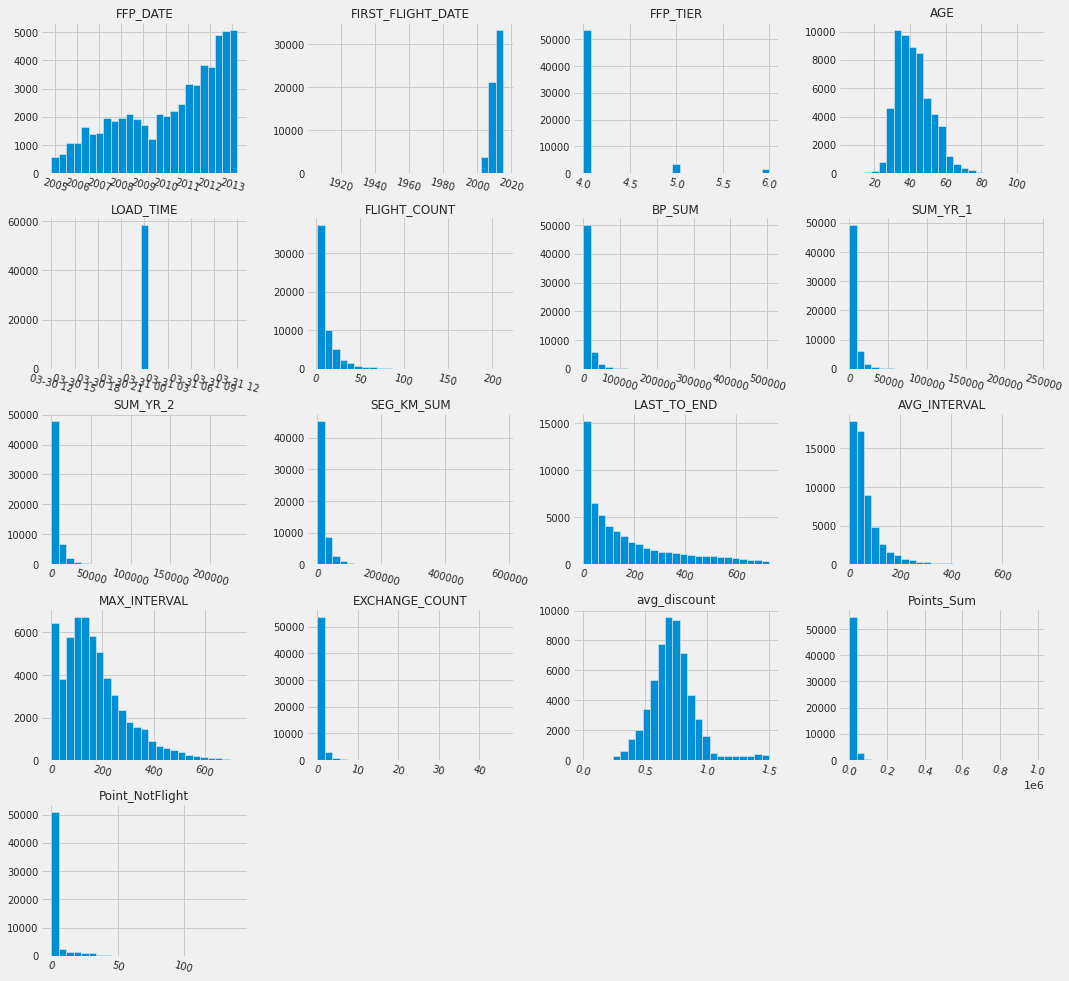

In [ ]:
# check data distribution with histogram

h = df.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

# (fig. 1-17)

**fig. 1-17, Explanation:**

Variable with normal distribution is `avg_discount`, while `FFP_DATE` and `FIRST_FLIGHT_DATE` is skewed to the right, which means the mean value is bigger than the median value. The rest of the variable [ `FFP_TIER`, `AGE`, `FLIGHT_COUNT`, `BP_SUM`, `SUM_YR_1`, `SUM_YR_2`, `SEG_KM_SUM`, `LAST_TO_END`, `ACG_INTERVAL`, `MAX_INTERVAL`, `EXCHANGE_COUNT`, `Points_Sum`, `Point_Notflight` ] skewed to the left, which means the median value is bigger than the mean value, we can see it from descriptive statistics table.

When the variable is skewed to the right means the bigger the data is, the more member use it, while when the variable skewed to the left, means the smaller the data, the more member use it.

For example :
1. `FFP_DATE` from fig. 1, from 2005, the numbers of first flyer increase each years.
2. `AGE` from fig. 4, the members are dominated by young flyer with age below 40, than the golden-ager. 

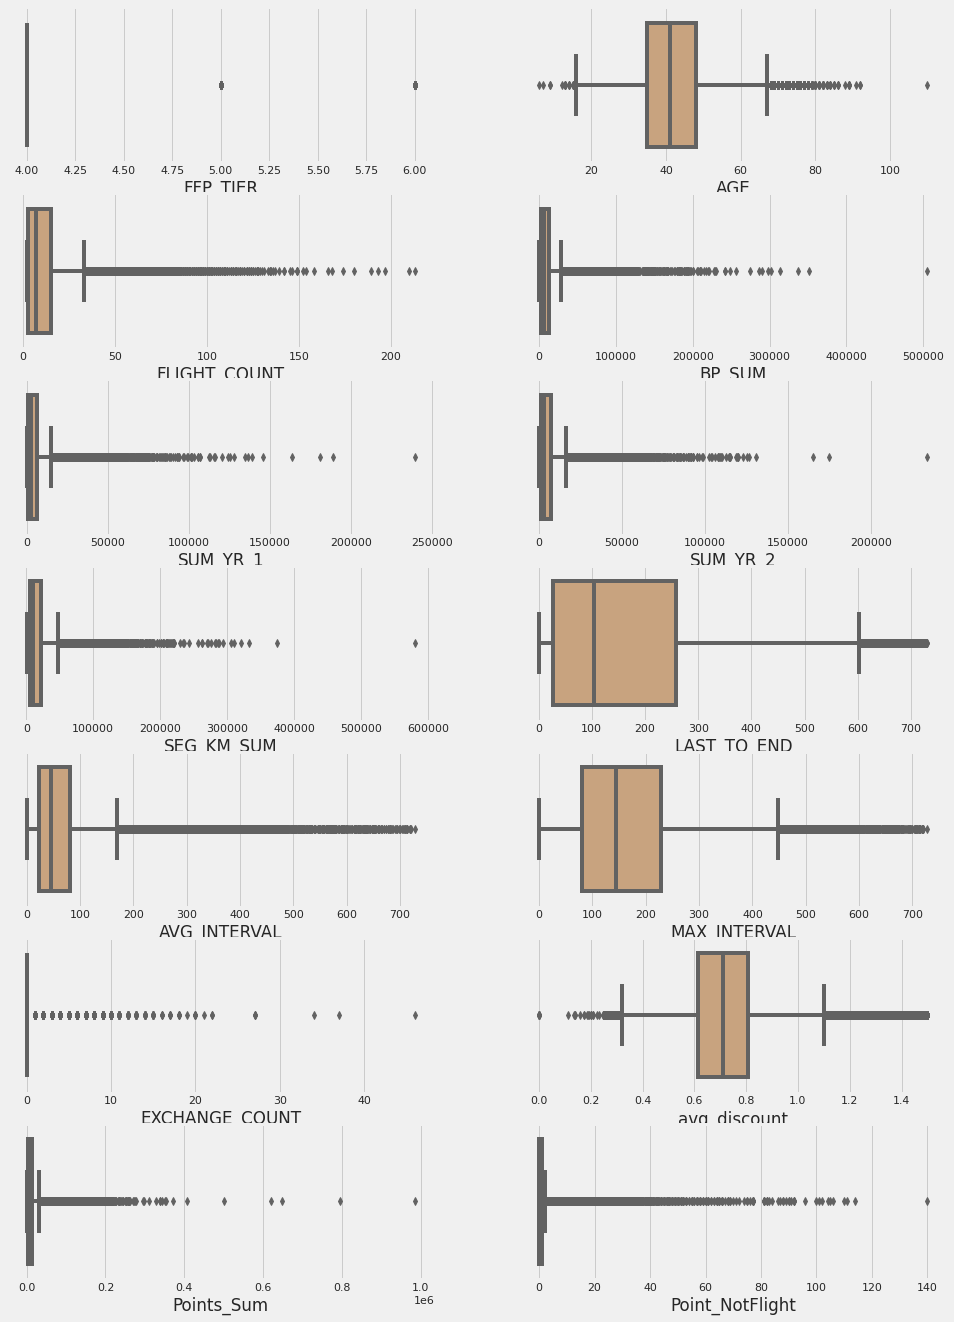

In [ ]:
# See is there any outliers in the dataframe

plt.figure(figsize=(15, 25))
for i in range(0, len(col_numericals)):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=df[col_numericals[i]], color='#d4a373')
    
plt.show()

# (fig. 18-31)

**fig. 18-31, Explanation:**

From 14 variables, all of the variables have outliers, which can create problem in our model. We can fix it with clustering.

### Multivariate Analysis

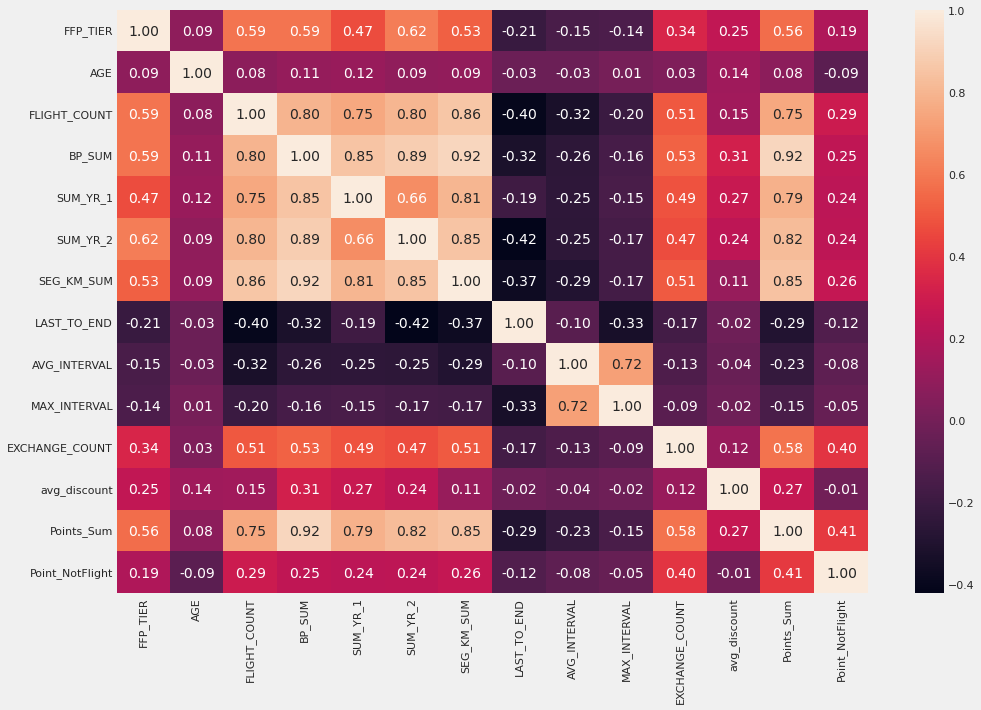

In [ ]:
# check the correlation heatmap

plt.figure(figsize=(15, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

# (fig. 32)

**fig. 32, Explanation:**

There are multicolinearity on every variables, and if we choose to clean it by removing the column/variable we may lost too many data.

## K-MEANS Clustering

### Brief Data Analysis

Before we do the clustering, we need to set our marketing targets and segmentations, and on this dataframe, we can see it by the customer's journey, or **marketing funnel**. We need to know the customer's initial stages from first joining the company. Marketing funnel can help know what your company must do to influence consumers at certain stages. By evaluating your funnels, you can potentially drive greater sales, more loyalty and stronger brand awareness.

We will use **TOFU-MOFU-BOFU** strategy which refers to the **top of funnel, middle of funnel, and bottom of funnel as distinct elements**. The abbreviations are used to describe tactics specific to each of the areas in the funnel. ToFu strategies are targeted at prospects in the awareness stage of the buyer’s journey, MoFu efforts are meant for consideration-stage prospects and BoFu tactics are targeted at decision-stage prospects.

**TOFU** <br>
Based on the description, the awareness stage, can be define as early stage of the membership, we can use `FFP_DATE` or customer's join date.

**MOFU** <br>
MOFU or middle of the funnel, where member already in for quite a while. We can help define it by using `Points_Sum` the total points, `avg_discount` average discount used by members, and `EXCHANGE_COUNT`how many points exchanged.

**BOFU** <br>
BOFU as the bottom of the funnel, we can say that in this stage, the member is loyal to us and spreading awareness towards other about the benefit. For BOFU we use `POINT_NOTFLIGHT`, `SEG_KM_SUM`, `AVG_INTERVAL`, and `FLIGHT_COUNT`.

[source 1](https://sproutsocial.com/glossary/marketing-funnel/) <br>
[source 2](https://www.newbreedrevenue.com/blog/tofu-mofu-bofu-tailoring-your-offers-to-the-buyers-journey#:~:text=ToFu%2C%20MoFu%20and%20BoFu%20Defined&text=ToFu%20stands%20for%20top%20of,the%20areas%20in%20the%20funnel)


In [ ]:
# creating new dataframe, containing selected variables for TOFU, MOFU, and BOFU

df_update = df[['FFP_DATE', 'Point_NotFlight', 'Points_Sum', 'avg_discount',
                'EXCHANGE_COUNT', 'SEG_KM_SUM','AVG_INTERVAL', 
                'FLIGHT_COUNT']]

df_update.head()

,FFP_DATE,Point_NotFlight,Points_Sum,avg_discount,EXCHANGE_COUNT,SEG_KM_SUM,AVG_INTERVAL,FLIGHT_COUNT
0,2006-11-02,50,619760,0.961639,34,580717,3.483254,210
2,2007-02-01,26,406361,1.254676,20,283712,5.298507,135
3,2008-08-22,12,372204,1.090870,11,281336,27.863636,23
4,2009-04-10,39,338813,0.970658,27,309928,4.788079,152
5,2008-02-10,15,343121,0.967692,10,294585,7.043956,92


### Data Scaling

In [ ]:
# scale the df_update dataframe

from sklearn.preprocessing import MinMaxScaler
for i in df_update:
            df_update[i] = MinMaxScaler().fit_transform(df_update[i].values.reshape(len(df_update), 1))

In [ ]:
df_update.head()

,FFP_DATE,Point_NotFlight,Points_Sum,avg_discount,EXCHANGE_COUNT,SEG_KM_SUM,AVG_INTERVAL,FLIGHT_COUNT
0,0.237956,0.357143,0.628833,0.641093,0.739130,1.000000,0.004785,0.985782
2,0.267578,0.185714,0.412310,0.836450,0.434783,0.488230,0.007278,0.630332
3,0.452474,0.085714,0.377653,0.727246,0.239130,0.484136,0.038274,0.099526
4,0.527669,0.278571,0.343773,0.647105,0.586957,0.533403,0.006577,0.710900
5,0.389323,0.107143,0.348144,0.645128,0.217391,0.506966,0.009676,0.426540


### K Identification

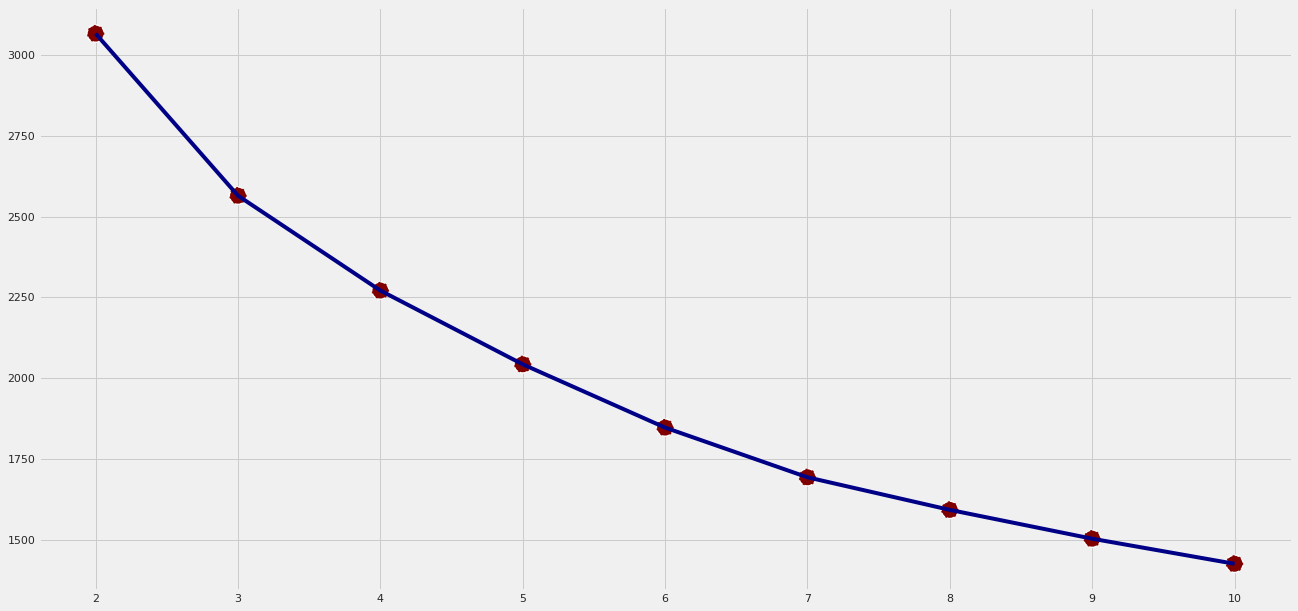

In [ ]:
# inertia

from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_update)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')
plt.show()

# fig. 33

From fig. 33, we can see that after reaching 4, the line smoothed, so we choose 4 as our K Value.

In [ ]:
# silhouette score

from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
print(range_n_clusters)


[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_update)
    preds = kmeans.predict(df_update)
     
    score_euclidean = silhouette_score(df_update, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

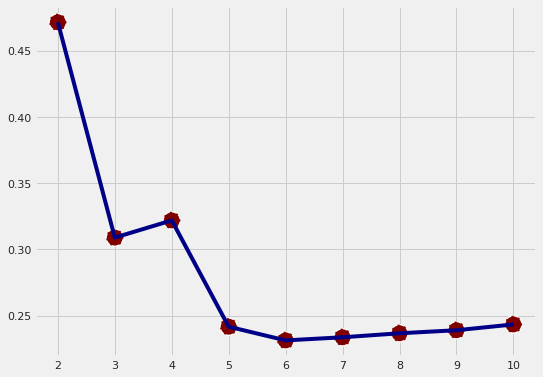

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, 
             color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, 
                color='#800000',  linestyle='--')

# fig. 34

From fig. 34, the provisioned K Value is 6. So, based on the inertia and silhoutte elbow calculation, we will use 4 as the new K Value

In [ ]:
# create copy dataframe, and add the cluster

new_df = df.copy()

kmeans = KMeans(n_clusters=4, random_state=0).fit(df_update)
clusters = kmeans.labels_
new_df['clusters'] = clusters
new_df.head(5)

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,...,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,clusters
0,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31.0,2014-03-31,210,...,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50,1
2,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40.0,2014-03-31,135,...,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26,1
3,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64.0,2014-03-31,23,...,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12,1
4,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48.0,2014-03-31,152,...,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39,2
5,2008-02-10,2009-09-29,Male,6,guangzhou,guangdong,CN,64.0,2014-03-31,92,...,294585,1/13/2014,79,7.043956,52,10,0.967692,343121,15,1


In [ ]:
# calculate the PCA

from sklearn.decomposition import PCA 

pca = PCA(n_components=2)

pca.fit(df_update)
pcs = pca.transform(df_update)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca['clusters'] = clusters

df_pca.head()

,PC 1,PC 2,clusters
0,0.525566,0.441372,1
1,0.457639,0.505559,1
2,0.230784,0.309549,1
3,0.199510,0.361813,2
4,0.308760,0.286648,1


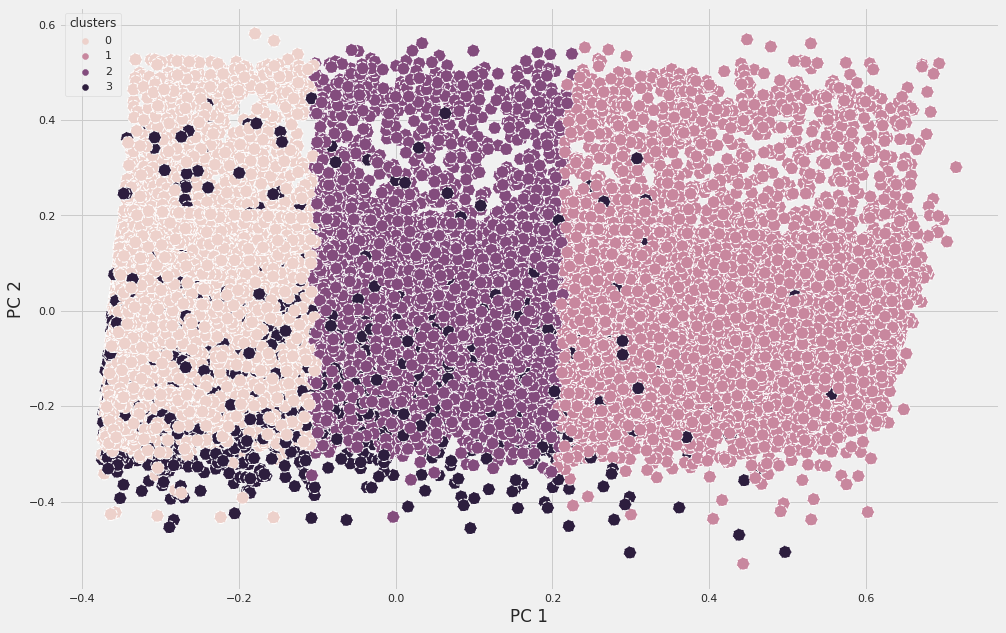

In [ ]:
# Visualize the clusters

fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_pca,
    s=160,
    ax=ax)


plt.show()

# fig. 35

In [ ]:
# filtering from new dataframe (new_df), selected topic needed, calculate the median values

new_df[['FFP_DATE', 'Point_NotFlight', 'Points_Sum', 'avg_discount',
        'EXCHANGE_COUNT', 'SEG_KM_SUM','AVG_INTERVAL',
        'FLIGHT_COUNT','clusters']].groupby('clusters').median()

,Point_NotFlight,Points_Sum,avg_discount,EXCHANGE_COUNT,SEG_KM_SUM,AVG_INTERVAL,FLIGHT_COUNT
clusters,,,,,,,
0,0.0,5595.0,0.701393,0.0,9246.5,43.516667,6.0
1,0.0,9066.0,0.725000,0.0,13863.0,40.666667,10.0
2,0.0,7753.0,0.715674,0.0,11699.0,42.833333,8.0
3,0.0,1986.0,0.691676,0.0,3359.0,286.000000,2.0


In [ ]:
# filtering from new dataframe (new_df), selected topic needed, calculate the mean values

new_df[['FFP_DATE', 'Point_NotFlight', 'Points_Sum', 'avg_discount',
        'EXCHANGE_COUNT', 'SEG_KM_SUM','AVG_INTERVAL',
        'FLIGHT_COUNT','clusters']].groupby('clusters').mean()

,Point_NotFlight,Points_Sum,avg_discount,EXCHANGE_COUNT,SEG_KM_SUM,AVG_INTERVAL,FLIGHT_COUNT
clusters,,,,,,,
0,1.850855,9669.995181,0.704737,0.096338,14443.369368,54.467952,9.898924
1,3.516707,17942.865617,0.745081,0.700257,22872.516180,58.838058,16.042773
2,3.845316,14196.342769,0.726748,0.388291,18886.353988,54.682550,13.307821
3,1.956196,3407.939723,0.694305,0.031449,4222.063647,322.165512,2.504306


Let's identified each clusters from scatter plot, fig. 35

Cluster 0

*   Medium amount of points [ `Points_Sum` ], with average around 9700 points, and low unused points [ 'Point_NotFlight` ]
*   Small amount of point exchange [ `EXCHANGE_COUNT` ]
*   Low to medium amount of miles [ `SEG_KM_SUM` ]
*   Low to medium average interval between flights [ `AVG_INTERVAL` ] and medium amount of taken flight [ `FLIGHT_COUNT` ]

Cluster 1

*   High amount of unused points [ `Point_NotFlight` ], and total points [ `Points_Sum` ] around 18000 points with high amount of point of exchange [ `EXCHANGE_COUNT` ]
*   Higher value of discount used, probably because member in this cluster has more choices and/or types of discounts [ `avg_discount` ]
*   High amount of miles [ `SEG_KM_SUM` ] and took more flight [ `FLIGHT_COUNT` ], but with the number of average interval between flights not too different with the low to medium flyer [ `AVG_INTERVAL` ]. It can caused by, in this cluster tend to do long or international flight than the other cluster.   

Cluster 2

*  Has similar trait with members in Cluster 1, only with smaller amount of expenses. 
*  Medium to Hight amount of total points [ `Points_Sum` ] and unused points [ `Point_NotFlight` ], with medium to high amount of point exchange [ `EXCHANGE_COUNT` ]
*  Number of flight taken is not far different with members in cluster 1 [ `FLIGHT_COUNT` ], and it has almost the same average interval time between flights with the cluster 0 [ `AVG_INTERVAL` ] but different amount of mileage [ `SEG_KM_SUM` ]
*  The amount of discount used by this level is in between the high and low medium flyer [ `avg_discount` ]

Cluster 3

*  Overall, in this cluster, members tends to spend a lot less than other clusters, has the lowest mileage and points, and the longest average interval between flights, than the other levels

From above identification, we can conclude that :
1. High Tier Flyer - Cluster 1 to 2
2. Medium Tier Flyer - Cluster 0
3. Low Tier Flyer - Cluster 3



In [ ]:
# calculate the amount of members in each cluster

cluster_df = new_df['clusters'].value_counts().to_frame().reset_index().rename(columns={"index": 
                                                                           "clusters", 
                                                                           "clusters": 
                                                                           "total_members"})
cluster_df

,clusters,total_members
0,0,24902
1,2,15509
2,1,15173
3,3,2671


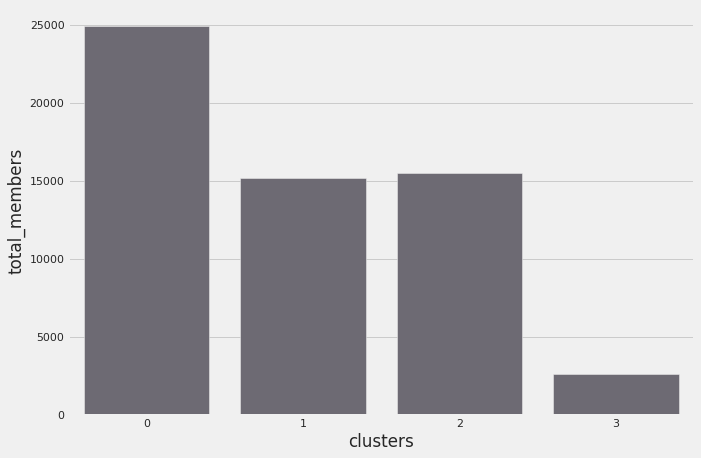

In [ ]:
# plot cluster barchart

plt.figure(figsize=(10, 7))

sns.barplot(
    x="clusters", 
    y="total_members", 
    data=cluster_df, 
    estimator=sum, 
    ci=None, 
    color='#6d6875');

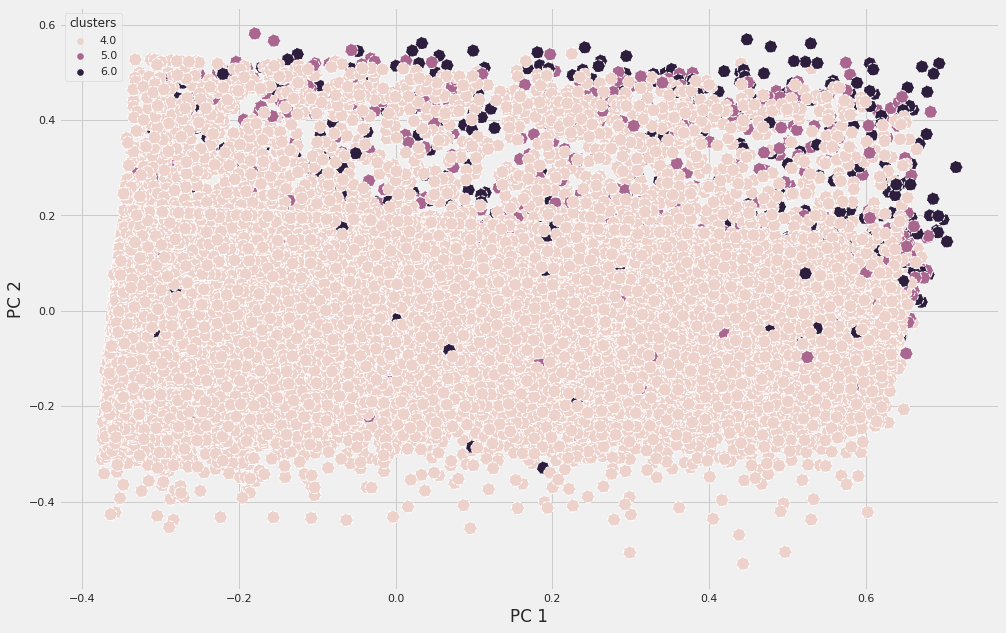

In [ ]:
# comparing the member tiers

df_ftier = df_pca.copy()
df_ftier['clusters'] = new_df['FFP_TIER']

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_ftier,
    s=160,
    ax=ax)

plt.show()

# fig. 36

Based on fig. 36, current tier classification from the airlines are divided to 3 types of clusters 4, 5 and 6. But the spread of data clustering is significantly different with our cluster, and it more bias with not much information gathered from the plot.

## Conclusion

1. Airline can change the membership tier, following our clustering calculation : High Tier Membership using **Cluster 1 to 2**, Medium Tier Membership using **Cluster 0**, while Low Tier Membership using **Cluster 3**

2. We need to gradually convert the lower tier members to higher level of membership, by increasing their loyalty and engagement level. We can lure the members with **free membership upgrade** and giving them **additional personal benefit**

3. Low tier membership has a long average time from one flight to another, to fix this problem, we can encourage the members to fly more by creating  a campaign like **travel affair** with **lots choices of discounts**, and give them an **exclusive offer** like additional discount, cashback, gift card, free meal [for long flight duration] or doubled the points for selected transactions.

4. The higher the mileage, means the more members using our services. So, we also need to convince them by giving them more attractive offers. Such as, they can exchange their mileage with more various choices and increasing the miles benefit.

5. For high tier membership, we can give them more enticing offers to help keep them loyal, so they will keep using the airlines even when it in **low season**, creating a travel package collaboration with resorts or hotel groups  
